In [ ]:
# Using MobileSAMv2 for region proposal and DINOv2 for feature extraction, use existing images from folder
# Background: White, How first workflow should ideally work
import cv2
import numpy as np
import os
from ultralytics import SAM

#Model Setup
sam_model = SAM('mobile_sam.pt')
input_folder = 'Test_images/perspective_2/'
output_file = 'Test_images/perspective_2/object_perspective_2.jpg'
target_height = 512  

#Load all images from the folder
valid_exts = ('.jpg', '.png', '.jpeg')
image_paths = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.lower().endswith(valid_exts)])

segmented_crops = []

print(f"Generating a white-background strip for {len(image_paths)} images using MobileSAMv2...")

for path in image_paths:
    if "messy_room" in path:
        continue
    img = cv2.imread(path)
    h, w, _ = img.shape
    
    #Prompt SAM with the center point to grab the foreground instance
    results = sam_model.predict(img, points=[[w//2, h//2]], labels=[1], verbose=False)
    
    if results[0].masks:

        mask = results[0].masks.data[0].cpu().numpy()
        mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        
        # Create a solid white background image
        white_bg = np.ones_like(img) * 255
        
        #Where mask is 1, keep original image; where mask is 0, use white background
        isolated = np.where(mask_3d > 0, img, white_bg).astype(np.uint8)
        
        #Crop to bounding box
        bx = results[0].boxes.xyxy[0].cpu().numpy().astype(int)
        crop = isolated[bx[1]:bx[3], bx[0]:bx[2]]
        
        #Resize to maintain constant height while preserving aspect ratio
        aspect_ratio = crop.shape[1] / crop.shape[0]
        new_width = int(target_height * aspect_ratio)
        crop_resized = cv2.resize(crop, (new_width, target_height))
        
        segmented_crops.append(crop_resized)

#Combine all images into one horizontal row
if segmented_crops:
    # np.hstack joins the list of arrays along the horizontal axis
    horizontal_strip = np.hstack(segmented_crops)
    
    cv2.imwrite(output_file, horizontal_strip)
    print(f"White background strip saved successfully as {output_file}")
else:
    print("No objects were segmented.")


import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image

#Setup DINOv2
# 'dinov2-small' is very fast; 'dinov2-base' or 'dinov2-giant' are more accurate
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
model = AutoModel.from_pretrained("facebook/dinov2-small").to(device)

def extract_features(crops_list):
    instance_library = []
    
    print(f"Extracting DINOv2 features for {len(crops_list)} perspectives...")
    
    for crop in crops_list:
        #Convert OpenCV BGR to PIL RGB for the transformer
        crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(crop_rgb)
        
        #Preprocess and move to device
        inputs = processor(images=pil_img, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            # The CLS token is the first token in the last hidden state
            # It provides a condensed 'fingerprint' of the whole image
            embeddings = outputs.last_hidden_state[:, 0, :]
            
            # Normalize the embedding (crucial for accurate cosine similarity matching)
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=-1)
            
            instance_library.append(embeddings.cpu().numpy())
            
    return instance_library


instance_features = extract_features(segmented_crops)
print(f"Library created with {len(instance_features)} feature vectors.")

Generating a white-background strip for 13 images using MobileSAMv2...
White background strip saved successfully as Test_images/perspective_2/object_perspective_2.jpg
Extracting DINOv2 features for 9 perspectives...
Library created with 9 feature vectors.


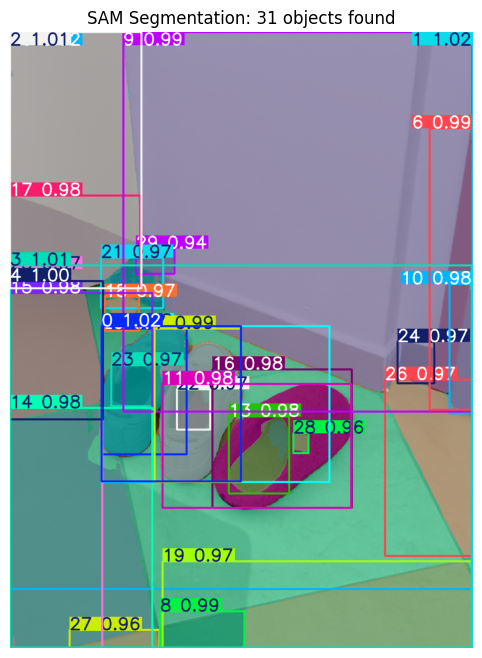

Analyzing 31 objects in the scene...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1 perspectives...
Extracting DINOv2 features for 1

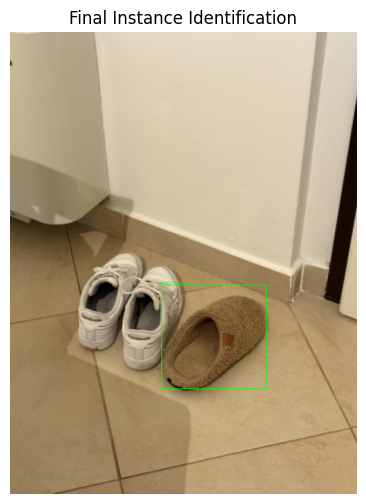

In [ ]:
#This is the actual part where a cluttered scene is scanned for object and the objects found are compared with features of my object
import torch
import cv2
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt # Needed for displaying in cell

def identify_in_scene(scene_path, reference_library, threshold=0.7):
    scene_img = cv2.imread(scene_path)
    if scene_img is None:
        print("Error: Scene image not found.")
        return
        
    #Get all object proposals from the scene
    scene_results = sam_model(scene_img) 
    annotated_frame = scene_results[0].plot()
    annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(annotated_frame_rgb)
    plt.title(f"SAM Segmentation: {len(scene_results[0].masks)} objects found")
    plt.axis('off')
    plt.show()

    best_overall_match = {"score": 0, "box": None, "view_idx": -1}

    print(f"Analyzing {len(scene_results[0].masks)} objects in the scene...")

    for i, mask_data in enumerate(scene_results[0].masks.data):
        # Isolate the candidate object with a white background
        mask = mask_data.cpu().numpy()
        mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        white_bg = np.ones_like(scene_img) * 255
        isolated = np.where(mask_3d > 0, scene_img, white_bg).astype(np.uint8)
        
        # Crop to the object
        box = scene_results[0].boxes.xyxy[i].cpu().numpy().astype(int)
        crop = isolated[box[1]:box[3], box[0]:box[2]]
        
        if crop is None or crop.size == 0 or crop.shape[0] < 5 or crop.shape[1] < 5:
            continue
            
        #Get DINOv2 Embedding/Features
        candidate_emb = extract_features([crop])[0] 
        
        # candidate_emb and ref_emb need to be 2D arrays (1, N)
        candidate_emb_res = candidate_emb.reshape(1, -1)
        
        scores = []
        for ref_emb in reference_library:
            ref_emb_res = ref_emb.reshape(1, -1)
            sim = cosine_similarity(candidate_emb_res, ref_emb_res)[0][0]
            scores.append(sim)
            
        max_score = max(scores)
        
        if max_score > best_overall_match["score"]:
            best_overall_match = {
                "score": max_score,
                "box": box,
                "view_idx": np.argmax(scores)
            }

    #Final Verification
    if best_overall_match["score"] > threshold:
        print(f"IDENTIFIED: Found your shoe! Match score: {best_overall_match['score']:.4f}")
        b = best_overall_match["box"]
        # Draw on a copy of the original image
        result_img = scene_img.copy()
        cv2.rectangle(result_img, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 5)
        cv2.putText(result_img, f"MATCH {best_overall_match['score']:.2f}", 
                    (b[0], b[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        # Show detection in cell
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title("Final Instance Identification")
        plt.axis('off')
        plt.show()
        
        cv2.imwrite("detection_result.jpg", result_img)
    else:
        print(f"Target not found. Best similarity: {best_overall_match['score']:.4f}")

# Run the search
#identify_in_scene("Test_images/perspective_2/messy_room.jpg", instance_features)
identify_in_scene("Test_images/perspective_2/messy_room4.jpg", instance_features)

In [ ]:
#Object scanning new approach: using video capture to capture the object: Object in this case is biggest captured object by SAM mobile
import cv2
import numpy as np
import torch
import time
from ultralytics import SAM
from transformers import AutoImageProcessor, AutoModel
from PIL import Image

#Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model = SAM('mobile_sam.pt')
processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
dino_model = AutoModel.from_pretrained("facebook/dinov2-small").to(device)

def get_dino_embedding(pil_img):
    inputs = processor(images=pil_img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = dino_model(**inputs)
        emb = torch.nn.functional.normalize(outputs.last_hidden_state[:, 0, :], p=2, dim=-1)
    return emb.cpu().numpy()

def adjust_lighting(img, alpha=1.0, beta=0):
    # alpha: contrast (1.0-3.0), beta: brightness (0-100) doesnt work yet
    return cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

def get_patches(img, grid_size=(2, 2)):
    h, w = img.shape[:2]
    patch_h, patch_w = h // grid_size[0], w // grid_size[1]
    patches = []
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            patch = img[i*patch_h:(i+1)*patch_h, j*patch_w:(j+1)*patch_w]
            patches.append(patch)
    return patches

#Camera interaction loop
cap = cv2.VideoCapture(0)
perspectives = []
print("Press 'SPACE' to capture a perspective. Need 6 total.")

while len(perspectives) < 6:
    ret, frame = cap.read()
    if not ret: break
    
    display_frame = frame.copy()
    cv2.putText(display_frame, f"Captured: {len(perspectives)}/6. Press SPACE", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.imshow("Scanner", display_frame)
    
    key = cv2.waitKey(1)
    if key == ord(' '):
        perspectives.append(frame)
        print(f"Captured perspective {len(perspectives)}")
        time.sleep(0.5)
    elif key == 27: #esc to exit
        break

cap.release()
cv2.destroyAllWindows()

#Data processing and augmentation
memory_bank = []
visual_grid = [] 

print("\nProcessing perspectives with SAM (Largest Object Mode) and DINOv2...")

for idx, img in enumerate(perspectives):
    h, w, _ = img.shape
    
    #Run SAM without points to find all potential objects
    results = sam_model.predict(img, verbose=False)
    
    if results[0].masks is not None:
        #Find the largest mask (likely the object being held)
        #We calculate the area by summing the boolean mask pixels
        areas = results[0].masks.data.sum(dim=(1, 2))
        largest_idx = torch.argmax(areas)
        
        # Extract the largest mask and its bounding box
        mask = results[0].masks.data[largest_idx].cpu().numpy()
        bx = results[0].boxes.xyxy[largest_idx].cpu().numpy().astype(int)
        
        #Isolate the object on a white background
        mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
        isolated = np.where(mask_3d > 0, img, 255).astype(np.uint8)
        
        # Crop to the object's full bounding box
        obj_crop = isolated[bx[1]:bx[3], bx[0]:bx[2]]
        
        
        # Save ORIGINAL WHOLE OBJECT
        pil_orig = Image.fromarray(cv2.cvtColor(obj_crop, cv2.COLOR_BGR2RGB))
        memory_bank.append(get_dino_embedding(pil_orig))
        visual_grid.append(obj_crop)
        

        # alpha: 1.05 (only 5% more contrast), beta: 10 (slight brightness)
        light_var = adjust_lighting(obj_crop, alpha=1.05, beta=10) 
        
        # alpha: 0.95 (only 5% less contrast), beta: -10 (slight dimming)
        dark_var = adjust_lighting(obj_crop, alpha=0.95, beta=-10)
        
        #Save LIGHT & DARK WHOLE OBJECTS
        for variant in [light_var, dark_var]:
            pil_var = Image.fromarray(cv2.cvtColor(variant, cv2.COLOR_BGR2RGB))
            memory_bank.append(get_dino_embedding(pil_var))
            visual_grid.append(variant)
            
            #Save 2 PATCHES per variation
            patches = get_patches(variant) 
            selected_patches = [patches[0], patches[3]] # Top-left and Bottom-right
            for p in selected_patches:
                pil_p = Image.fromarray(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))
                memory_bank.append(get_dino_embedding(pil_p))
                visual_grid.append(p)
    else:
        print(f"⚠️ Warning: No object found in perspective {idx+1}")

print(f"Total Feature Vectors Created: {len(memory_bank)}")

# Simple visualization of first few masks/patches
if visual_grid:
    # Resize patches for uniform grid
    grid_display = [cv2.resize(p, (100, 100)) for p in visual_grid[:12]]
    top_row = np.hstack(grid_display[:6])
    bottom_row = np.hstack(grid_display[6:12])
    combined_preview = np.vstack([top_row, bottom_row])
    cv2.imshow("Extracted Patch Samples", combined_preview)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


print("\nCreating visual dashboards...")

for i in range(len(perspectives)):
    start = i * 7
    p_set = visual_grid[start : start + 7]
    
    # Standardize sizes for the grid
    # Large size for the 3 "Whole" images, small for the 4 patches
    big_size = (200, 200) 
    small_size = (150, 150)
    
    # Resize Globals (Original, Light, Dark)
    globals_row = [cv2.resize(img, big_size) for img in p_set[0:3]]
    top_bar = np.hstack(globals_row) # 3 across
    
    # Resize Patches (2 Light, 2 Dark)
    patches_row = [cv2.resize(img, small_size) for img in p_set[3:7]]
    bottom_bar = np.hstack(patches_row) # 4 across
    
    # Since the rows have different widths (3*200=600 vs 4*150=600), they match!
    # Stack them vertically
    perspective_dashboard = np.vstack([top_bar, bottom_bar])
    
    # Add a title overlay
    cv2.putText(perspective_dashboard, f"Perspective {i+1}: Globals (Top) | Patches (Bottom)", 
                (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display and Save
    cv2.imshow(f"Dashboard_P{i+1}", perspective_dashboard)
    cv2.imwrite(f"dashboard_perspective_{i+1}.jpg", perspective_dashboard)

print("Dashboards created. Press any key to exit.")
cv2.waitKey(0)
cv2.destroyAllWindows()

/Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/.cvenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/annikaunmuessig/Developer/University/Group_Projects/Project_CV/.cvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Press 'SPACE' to capture a perspective. Need 6 total.
Captured perspective 1
Captured perspective 2
Captured perspective 3
Captured perspective 4
Captured perspective 5
Captured perspective 6

Processing perspectives with SAM (Largest Object Mode) and DINOv2...


KeyboardInterrupt: 

In [ ]:
#Attempt with SAM 2 
import cv2
import numpy as np
import torch
import os
import time
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

#Setup Device and Model
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = "models/sam2/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

#Folder Setup for Multi-View Memory
session_id = f"object_{int(time.time())}"
output_folder = os.path.join("multi_view", session_id)
os.makedirs(output_folder, exist_ok=True)

cap = cv2.VideoCapture(0)
saved_mask = None
view_counter = 0
last_capture_time = 0

print(f"Session Started: Saving to {output_folder}")
print("Point at object and HOLD 's' to capture multiple angles.")

while True:
    ret, frame = cap.read()
    if not ret: break
    
    h, w = frame.shape[:2]
    center_x, center_y = w // 2, h // 2
    
    # UI: Crosshair and Targeting Box
    cv2.circle(frame, (center_x, center_y), 5, (0, 0, 255), -1)
    cv2.rectangle(frame, (center_x-30, center_y-30), (center_x+30, center_y+30), (255, 255, 255), 1)

    key = cv2.waitKey(1) & 0xFF

    #Multi-View Capture Logic
    if key == ord('s'):
        if time.time() - last_capture_time > 0.7:
            predictor.set_image(frame)

            off = 20
            input_pts = np.array([
                [center_x, center_y], 
                [center_x+off, center_y], [center_x-off, center_y],
                [center_x, center_y+off], [center_x, center_y-off]
            ])
            input_lbls = np.array([1, 1, 1, 1, 1])

            masks, scores, _ = predictor.predict(
                point_coords=input_pts,
                point_labels=input_lbls,
                multimask_output=True 
            )
            
            #Index 2 is the 'Whole Object' mask in SAM 2
            best_mask = masks[2]
            saved_mask = best_mask
            
            #Create RGBA Image (Transparent Background)
            mask_alpha = (best_mask.astype(np.uint8) * 255)
            if mask_alpha.ndim == 3: mask_alpha = mask_alpha.squeeze(0)
            
            b, g, r = cv2.split(frame)
            rgba = cv2.merge([b, g, r, mask_alpha])
            
            #Save the segmented view
            filename = os.path.join(output_folder, f"view_{view_counter:03d}.png")
            cv2.imwrite(filename, rgba)
            
            print(f"Saved View {view_counter} | Confidence: {np.max(scores):.2f}")
            view_counter += 1
            last_capture_time = time.time()

    #Visualization
    display_frame = frame.copy()
    if saved_mask is not None:
        mask_bool = saved_mask.astype(bool)
        if mask_bool.ndim == 3: mask_bool = mask_bool.squeeze(0)
        
        #Apply green tint to the most recently captured object
        overlay = display_frame.copy()
        overlay[mask_bool] = [0, 255, 0]
        cv2.addWeighted(overlay, 0.4, display_frame, 0.6, 0, display_frame)

    cv2.imshow('Multi-View Enrollment (Press S to Save, Q to Quit)', display_frame)
    
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Session Started: Saving to multi_view/object_1768843799
Point at object and HOLD 's' to capture multiple angles.
Saved View 0 | Confidence: 0.89
Saved View 1 | Confidence: 0.89
Saved View 2 | Confidence: 0.90
Saved View 3 | Confidence: 0.95
Saved View 4 | Confidence: 0.93
Saved View 5 | Confidence: 0.91
Saved View 6 | Confidence: 0.93
Saved View 7 | Confidence: 0.92
Saved View 8 | Confidence: 0.91
Saved View 9 | Confidence: 0.93
Saved View 10 | Confidence: 0.93
Saved View 11 | Confidence: 0.92
